In [1]:
from __future__ import print_function
import numpy as np
from PIL import Image

from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input,decode_predictions

Using TensorFlow backend.


In [2]:
from keras import backend
from keras.models import Model
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave

In [3]:
content_image=Image.open('vlc.png')
content_image=content_image.resize((512,512))

In [4]:
style_image= Image.open('style.png')
style_image=style_image.resize((512,512))

In [5]:
style_image.size

(512, 512)

In [6]:
content_array=np.asarray(content_image,dtype='float32')
content_array=np.expand_dims(content_array,axis=0)
#content_array=np.array(content_array).copy()

In [7]:
style_array=np.asarray(style_image,dtype='float32')
style_array=np.expand_dims(style_array,axis=0)
#backend.sum(backend.square(S - C)) / (4. * (channels ** 2) * (size ** 2))style_array=np.array(style_array).copy()
print(content_array.shape)
print(style_array.shape)

(1, 512, 512, 3)
(1, 512, 512, 3)


In [8]:
content_array[:, :, :, 0] -= 103.939
content_array[:, :, :, 1] -= 116.779
content_array[:, :, :, 2] -= 123.68
content_array=content_array[:, :, :, ::-1]

In [9]:
style_array[:, :, :, 0] -= 103.939
style_array[:, :, :, 1] -= 116.779
style_array[:, :, :, 2] -= 123.68
style_array=style_array[:, :, :, ::-1]
style_array.shape

(1, 512, 512, 3)

In [10]:
height=512
width=512
content_image=backend.variable(content_array)
style_image=backend.variable(style_array)
combination_image=backend.placeholder((1,height,width,3))

Instructions for updating:
Colocations handled automatically by placer.


In [11]:
input_tensor=backend.concatenate([content_image,style_image,combination_image],axis=0)

In [12]:
model=VGG16(input_tensor=input_tensor,weights='imagenet', include_top=False)

In [13]:
content_weight = 1.0
style_weight = 500.0
total_variation_weight = 1.0

In [14]:
layers=dict([(layer.name, layer.output) for layer in model.layers])
print(layers)

{'input_1': <tf.Tensor 'concat:0' shape=(3, 512, 512, 3) dtype=float32>, 'block1_conv1': <tf.Tensor 'block1_conv1/Relu:0' shape=(3, 512, 512, 64) dtype=float32>, 'block1_conv2': <tf.Tensor 'block1_conv2/Relu:0' shape=(3, 512, 512, 64) dtype=float32>, 'block1_pool': <tf.Tensor 'block1_pool/MaxPool:0' shape=(3, 256, 256, 64) dtype=float32>, 'block2_conv1': <tf.Tensor 'block2_conv1/Relu:0' shape=(3, 256, 256, 128) dtype=float32>, 'block2_conv2': <tf.Tensor 'block2_conv2/Relu:0' shape=(3, 256, 256, 128) dtype=float32>, 'block2_pool': <tf.Tensor 'block2_pool/MaxPool:0' shape=(3, 128, 128, 128) dtype=float32>, 'block3_conv1': <tf.Tensor 'block3_conv1/Relu:0' shape=(3, 128, 128, 256) dtype=float32>, 'block3_conv2': <tf.Tensor 'block3_conv2/Relu:0' shape=(3, 128, 128, 256) dtype=float32>, 'block3_conv3': <tf.Tensor 'block3_conv3/Relu:0' shape=(3, 128, 128, 256) dtype=float32>, 'block3_pool': <tf.Tensor 'block3_pool/MaxPool:0' shape=(3, 64, 64, 256) dtype=float32>, 'block4_conv1': <tf.Tensor 'b

In [15]:
loss=backend.variable(0.)

In [16]:
def content_loss(content, combination):
    return backend.sum(backend.square(content-combination))

In [17]:
layer_features=layers['block1_conv2']
content_image_features=layer_features[0,:,:,:]
print(content_image_features)
combination_features=layer_features[2,:,:,:]
print(combination_features)
loss+=content_weight*content_loss(content_image_features,combination_features)

Tensor("strided_slice:0", shape=(512, 512, 64), dtype=float32)
Tensor("strided_slice_1:0", shape=(512, 512, 64), dtype=float32)


In [18]:
def gram_matrix(x):
    features=backend.batch_flatten(backend.permute_dimensions(x,(2,0,1)))
    gram=backend.dot(features, backend.transpose(features))
    return gram

In [19]:
def style_loss(style,combination):
    S=gram_matrix(style)
    C=gram_matrix(combination)
    channels=3
    size=height * width
    st=backend.sum(backend.square(S - C)) / (4. * (channels ** 2) * (size ** 2))
    return st

In [20]:
feature_layers = ['block5_conv1', 'block5_conv2',
                  'block5_conv3']

In [21]:
for layer_name in feature_layers:
    layer_features=layers[layer_name]
    style_features=layer_features[1,:,:,:]
    combination_features=layer_features[2,:,:,:]
    sl=style_loss(style_features,combination_features)
    loss+=(style_weight/len(feature_layers))*sl

In [22]:
def total_variation_loss(x):
    a=backend.square(x[:,:height-1,:width-1,:]-x[:,1:,:width-1,:])
    b = backend.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return backend.sum(backend.pow(a + b, 1.25))
loss += total_variation_weight * total_variation_loss(combination_image)

In [23]:
grads = backend.gradients(loss, combination_image)

In [24]:
outputs=[loss]
if isinstance(grads, (list, tuple)):
    outputs += grads
else:
    outputs.append(grads)
f_outputs = backend.function([combination_image], outputs)

In [25]:
def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

In [26]:
class Evaluator(object):
    def __init__(self):
        self.loss_value=None
        self.grads_values=None
    
    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

In [27]:
evaluator=Evaluator()

In [28]:
x=np.random.uniform(0,255,(1,height,width,3))-128.0

iterations = 10

In [29]:
import time
for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                           fprime=evaluator.grads, maxfun=20)
    print(min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
4856275000.0
Iteration 0 completed in 74s
Start of iteration 1
3758247000.0
Iteration 1 completed in 73s
Start of iteration 2
3749056000.0
Iteration 2 completed in 74s
Start of iteration 3
3748538000.0
Iteration 3 completed in 74s
Start of iteration 4
3748451600.0
Iteration 4 completed in 74s
Start of iteration 5
3748422000.0
Iteration 5 completed in 74s
Start of iteration 6
3748409600.0
Iteration 6 completed in 74s
Start of iteration 7
3748409000.0
Iteration 7 completed in 77s
Start of iteration 8
3748408800.0
Iteration 8 completed in 63s
Start of iteration 9
3748408800.0
Iteration 9 completed in 71s


In [30]:
print
x = x.reshape((height, width, 3))
x = x[:, :, ::-1]
x[:, :, 0] += 103.939
x[:, :, 1] += 116.779
x[:, :, 2] += 123.68
x = np.clip(x, 0, 255).astype('uint8')


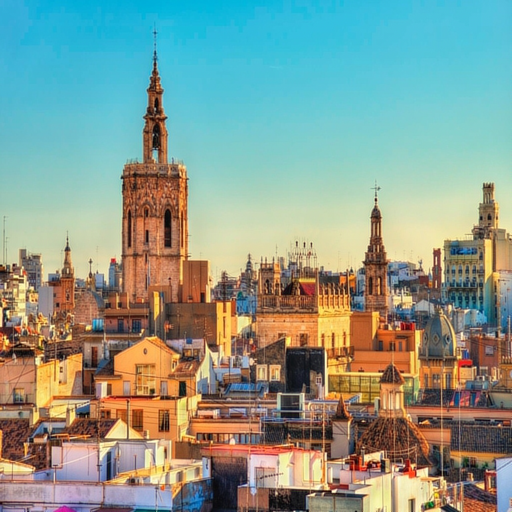

In [31]:
Image.fromarray(x)